## Import CSV

In [146]:
import pandas
def read_csv(filename,folder):
    folder=folder+"/"+filename+".csv"
    return pandas.read_csv(folder,encoding='ISO-8859-1')

In [147]:
folder="/root/bigdataanalysis/test/"
data=read_csv(filename="FEAT_DATA",folder=folder)
data = data.fillna(method='ffill')
data.head()

,Date,VFINX,VBMFX,VIX.chg,VIX.ret,SPX_SMA,VFINX_SKW,VBMFX_SKW,VIX_SKW
0,1992/7/31,0.040435,0.019139,0.990000,0.054396,59.404538,0.147270,-0.361634,1.611413
1,1992/8/31,-0.020678,0.009810,1.180001,0.074542,42.446817,0.203045,-0.383036,1.611591
2,1992/9/30,0.011695,0.012619,1.360000,0.084002,42.076810,0.234685,-0.484301,1.619356
3,1992/10/31,0.003287,-0.012196,2.219999,0.146149,38.072277,0.197649,-0.537942,1.608442
4,1992/11/30,0.034022,-0.000232,0.660000,0.031399,49.122285,0.083761,-0.564753,1.583007


## Visualize Data

In [123]:
from matplotlib import pyplot
def plot_data(dataset,groups):
    i = 1
    pyplot.figure()
    values = dataset.values
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.5, loc='right')
        i += 1
    pyplot.show()

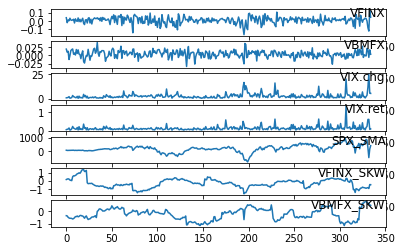

In [124]:
plot_data(data,groups=list(range(1,8)))

## Data Summary

In [125]:
data.describe()

,VFINX,VBMFX,VIX.chg,VIX.ret,SPX_SMA,VFINX_SKW,VBMFX_SKW,VIX_SKW
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,0.008500,0.004442,2.933612,0.132894,172.861865,-0.317719,-0.252150,1.984365
std,0.041888,0.010269,2.739455,0.121426,270.439242,0.529763,0.429091,0.722695
min,-0.167924,-0.033379,0.520000,0.027213,-828.955472,-1.591634,-1.130117,0.355788
25%,-0.015477,-0.001658,1.350000,0.068684,48.795472,-0.637919,-0.563336,1.613261
50%,0.013334,0.004791,2.209999,0.100211,175.974099,-0.331041,-0.228512,1.946692
75%,0.034467,0.011091,3.425000,0.151396,315.193620,0.054553,0.079435,2.386150
max,0.128139,0.039527,24.860000,1.352941,994.525901,1.352074,0.741078,3.793871


## Independent and identically distributed (I.I.D.) Testing

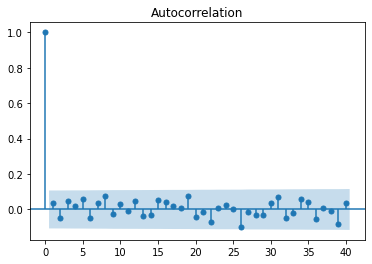

In [126]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
sm.graphics.tsa.plot_acf(data['VFINX'].values, lags=40)
plt.show()

## Histogram

<AxesSubplot:ylabel='Frequency'>

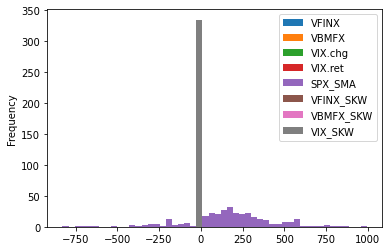

In [127]:
data.plot(kind="hist",bins=50)

## Normal Test 

In [128]:
from scipy import stats
print(stats.shapiro(data['VFINX'].values))
print(stats.shapiro(data['VBMFX'].values))

ShapiroResult(statistic=0.9699879884719849, pvalue=2.0183554170216667e-06)
ShapiroResult(statistic=0.9902392625808716, pvalue=0.025059891864657402)


## *** LSTM ***

In [129]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
def Standard_MinMax(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    return sc.fit_transform(data.reshape(-1,1))

In [130]:
folder="/root/bigdataanalysis/test/"
data=read_csv(filename="FEAT_DATA",folder=folder)
del data['Date']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
data.head()

,VFINX,VBMFX,VIX.chg,VIX.ret,SPX_SMA,VFINX_SKW,VBMFX_SKW,VIX_SKW
0,0.040435,0.019139,0.990000,0.054396,59.404538,0.147270,-0.361634,1.611413
1,-0.020678,0.009810,1.180001,0.074542,42.446817,0.203045,-0.383036,1.611591
2,0.011695,0.012619,1.360000,0.084002,42.076810,0.234685,-0.484301,1.619356
3,0.003287,-0.012196,2.219999,0.146149,38.072277,0.197649,-0.537942,1.608442
4,0.034022,-0.000232,0.660000,0.031399,49.122285,0.083761,-0.564753,1.583007


## Series to Supervised

In [131]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [132]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.703769,0.720346,0.019310,0.020504,0.487178,0.590719,0.410691,0.365211,0.497349,0.592389,0.027116,0.035700,0.477878,0.609666,0.399254,0.365262
2,0.497349,0.592389,0.027116,0.035700,0.477878,0.609666,0.399254,0.365262,0.606692,0.630925,0.034511,0.042836,0.477675,0.620414,0.345136,0.367521
3,0.606692,0.630925,0.034511,0.042836,0.477675,0.620414,0.345136,0.367521,0.578293,0.290552,0.069844,0.089713,0.475479,0.607833,0.316469,0.364347
4,0.578293,0.290552,0.069844,0.089713,0.475479,0.607833,0.316469,0.364347,0.682107,0.454656,0.005752,0.003157,0.481539,0.569145,0.302141,0.356949
5,0.682107,0.454656,0.005752,0.003157,0.481539,0.569145,0.302141,0.356949,0.608117,0.660285,0.013558,0.016470,0.482352,0.554840,0.303656,0.406741


In [133]:
pred = {'VFINX': 8}
reframed = pandas.concat([reframed.iloc[:,0:8],reframed.iloc[:,pred['VFINX']]],axis=1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.703769,0.720346,0.019310,0.020504,0.487178,0.590719,0.410691,0.365211,0.497349
2,0.497349,0.592389,0.027116,0.035700,0.477878,0.609666,0.399254,0.365262,0.606692
3,0.606692,0.630925,0.034511,0.042836,0.477675,0.620414,0.345136,0.367521,0.578293
4,0.578293,0.290552,0.069844,0.089713,0.475479,0.607833,0.316469,0.364347,0.682107
5,0.682107,0.454656,0.005752,0.003157,0.481539,0.569145,0.302141,0.356949,0.608117


## Data Split

In [134]:
train = reframed.values[:300,:]
test = reframed.values[300:334,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y  = test[:, :-1], test[:, -1]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((300, 8), (300,), (34, 8), (34,))

## LSTM

In [135]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

import keras
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


## Training

In [136]:
history = model.fit(train_X, train_y, epochs=100, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Epoch 1/100
5/5 [==============================] - 0s 73ms/step - loss: 0.3831 - val_loss: 0.3266
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.3114 - val_loss: 0.2559
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.2478 - val_loss: 0.1946
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 0.1919 - val_loss: 0.1429
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1439 - val_loss: 0.1012
Epoch 6/100
5/5 [==============================] - 0s 16ms/step - loss: 0.1039 - val_loss: 0.0699
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0723 - val_loss: 0.0492
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0494 - val_loss: 0.0387
Epoch 9/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0345 - val_loss: 0.0367
Epoch 10/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0266 - val_loss: 0.0401
Epoch 11/100
5/5 [=====

## Plot Loss Curve

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'real']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


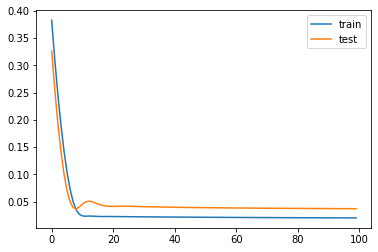

In [137]:
%pylab inline
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predict

In [138]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhat.shape, test_X.shape

((34, 1), (34, 8))

## Invert scaling for forecast

In [139]:
pred = {'VFINX': 0}
inv_yhat = concatenate((yhat, numpy.delete(test_X, pred['VFINX'], axis=1)), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat.shape

(34,)

## Invert scaling for actual

In [140]:
real = test_y.reshape((len(test_y), 1))
inv_y = concatenate((real, numpy.delete(test_X, pred['VFINX'], axis=1)), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y.shape

(34,)

## RMSE

In [141]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.057


In [142]:
inv_y = np.cumprod(inv_y+1)
inv_yhat = np.cumprod(inv_yhat+1)

## Predict vs Real

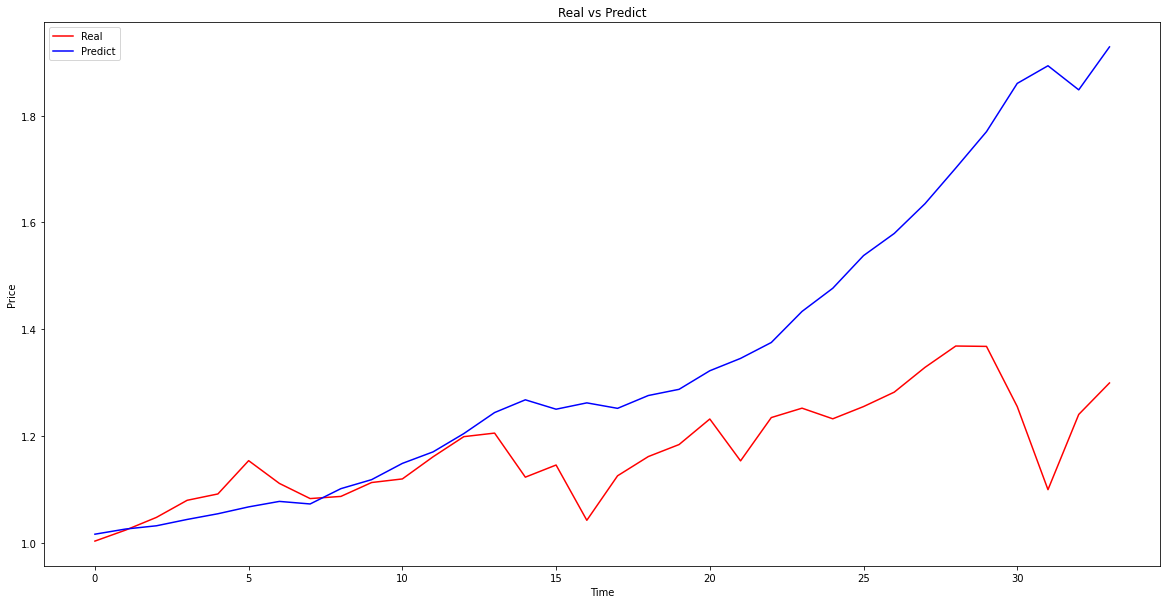

In [143]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(inv_y, color = 'red', label = 'Real')
plt.plot(inv_yhat, color = 'blue', label = 'Predict')
plt.title('Real vs Predict')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## CNN Data Split (same with LSTM)

In [104]:
train = reframed.values[:300,:]
test = reframed.values[300:334,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y  = test[:, :-1], test[:, -1]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((300, 8), (300,), (34, 8), (34,))

## CNN Data Split

In [105]:
from keras.layers import Activation, Dense
model = keras.Sequential()
model.add(Dense(5, activation='relu', input_shape=(8,)))
model.add(Dense(5, activation='relu'))
model.add(Dense(1,  activation='sigmoid'))
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae','mse'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 6         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


## Training

In [106]:
history = model.fit(train_X, train_y, epochs=100, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Epoch 1/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0271 - mae: 0.1356 - mse: 0.0271 - val_loss: 0.0359 - val_mae: 0.1617 - val_mse: 0.0359
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0264 - mae: 0.1334 - mse: 0.0264 - val_loss: 0.0353 - val_mae: 0.1593 - val_mse: 0.0353
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0257 - mae: 0.1312 - mse: 0.0257 - val_loss: 0.0346 - val_mae: 0.1567 - val_mse: 0.0346
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0250 - mae: 0.1290 - mse: 0.0250 - val_loss: 0.0339 - val_mae: 0.1541 - val_mse: 0.0339
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0243 - mae: 0.1268 - mse: 0.0243 - val_loss: 0.0333 - val_mae: 0.1515 - val_mse: 0.0333
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0236 - mae: 0.1247 - mse: 0.0236 - val_loss: 0.0327 - val_mae: 0.1489 - val_mse: 0.0327
Epoch 7/100
5/5 [===============

## Plot Loss Curve

Populating the interactive namespace from numpy and matplotlib


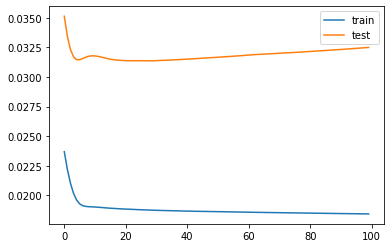

In [39]:
%pylab inline
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predict

In [40]:
yhat = model.predict(test_X)
yhat.shape, test_X.shape

((34, 1), (34, 8))

In [41]:
pred = {'VFINX': 0}
inv_yhat = concatenate((yhat, numpy.delete(test_X, pred['VFINX'], axis=1)), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat.shape

(34,)

In [42]:
real = test_y.reshape((len(test_y), 1))
inv_y = concatenate((real, numpy.delete(test_X, pred['VFINX'], axis=1)), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y.shape

(34,)

In [43]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.053


In [44]:
inv_y = np.cumprod(inv_y+1)
inv_yhat = np.cumprod(inv_yhat+1)

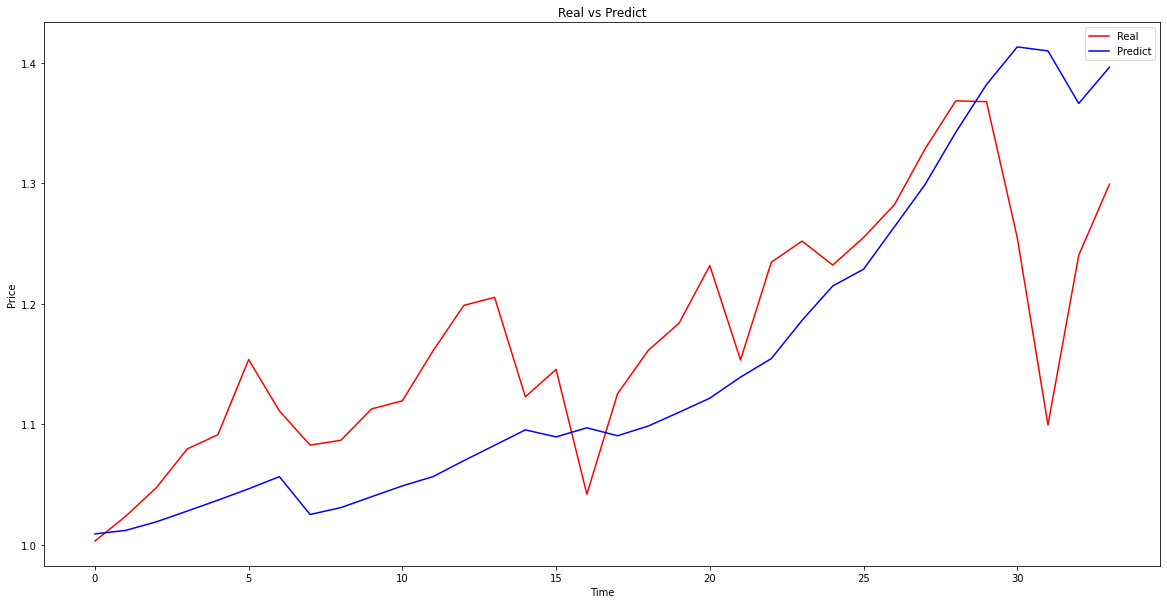

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(inv_y, color = 'red', label = 'Real')
plt.plot(inv_yhat, color = 'blue', label = 'Predict')
plt.title('Real vs Predict')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## *** SVM Classification ***

In [48]:
folder="C:/Users/user/Desktop/NCCU_DB/DataBase"
data=read_csv(filename="FEAT_DATA",folder=folder)
data.head()

,Date,VBMFX,VFINX,VIX.chg,VIX.ret,SPX_SMA,VFINX_SKW,VBMFX_SKW,VIX_SKW
0,2020/5/29,0.003475,0.047559,5.470001,0.095864,400.036400,-0.478190,0.439268,2.747991
1,2020/4/30,0.016932,0.128139,5.680000,0.068690,147.717885,-0.468298,0.471941,2.754459
2,2020/3/31,-0.005856,-0.124013,24.860000,0.619796,-500.768910,-0.952582,0.596769,2.762359
3,2020/2/28,0.017066,-0.082413,11.600001,0.615711,239.538152,-0.840620,0.599255,3.167991
4,2020/1/31,0.021187,-0.000503,3.670000,0.229950,816.021351,-0.870556,0.657260,3.488195


## Data convert to Relative Change

In [49]:
import numpy
y = data['VFINX']
#x = data[['VBMFX','VIX.chg','VIX.ret','SPX_SMA','VFINX_SKW','VBMFX_SKW','VIX_SKW']]
x = data[['VIX.ret','SPX_SMA']]
x.head()

,VIX.ret,SPX_SMA
0,0.095864,400.036400
1,0.068690,147.717885
2,0.619796,-500.768910
3,0.615711,239.538152
4,0.229950,816.021351


## Y convert to Category

In [50]:
#y = (y-y.mean())/y.std()
y = numpy.where(y>0, 1, 0)
#y = numpy.where(y>1, 1, numpy.where(y<-1, -1, 0))

In [51]:
from sklearn.model_selection     import train_test_split
x_train, x_test, y_train, y_test =  train_test_split(x,y, test_size = 0.33, random_state = 42 )

## Standardize Function

In [52]:
from sklearn.preprocessing       import StandardScaler
def Standard(data):
    sc = StandardScaler()
    # fit_transform will fixed mean & vol by data
    # transform reuse above mean & vol
    return sc.fit_transform(data)

In [53]:
x = Standard(x)
x.shape

(335, 2)

## SVM Classifier

In [54]:
def plot_classifier(data,target,type,C=100,svc_kernel="rbf"):
    if type == 'SVC':
        from sklearn.svm import SVC
        clf = SVC(C=C,kernel=svc_kernel)
        clf.fit(data, target)
    if type == 'Logistic':
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression()
        clf.fit(data, target)
    plot_estimator(estimator=clf, data=data ,target=target)
    
def plot_estimator(estimator, data, target):
    # *** estimator model must trained by two variables ***
    x_min, x_max = data[:, 0].min() - 0.02, data[:, 0].max() + 0.02
    y_min, y_max = data[:, 1].min() - 0.02, data[:, 1].max() + 0.02
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, 0.005), numpy.arange(y_min, y_max, 0.005))
    Z = estimator.predict(numpy.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.plot()
    plt.contourf(xx, yy, Z, alpha=0.4, cmap = plt.cm.RdYlBu)
    plt.scatter(data[:, 0], data[:, 1], c=target, cmap = plt.cm.brg)
    plt.xlabel('Index Return')
    plt.ylabel('Dividend Growth')
    plt.show()

## Plot Decision Boundary

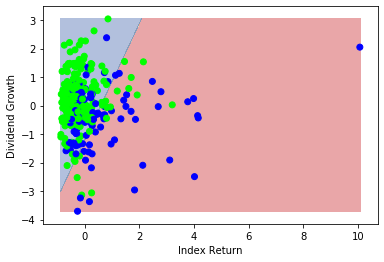

In [55]:
import matplotlib.pyplot as plt
plot_classifier(data=x,target=y,type="SVC",svc_kernel="linear",C=100)

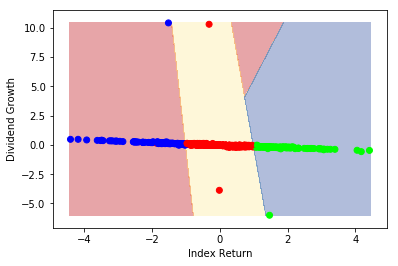

In [72]:
plot_classifier(data=x[:1000,:],target=y[:1000],type="SVC",svc_kernel="linear",C=100)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


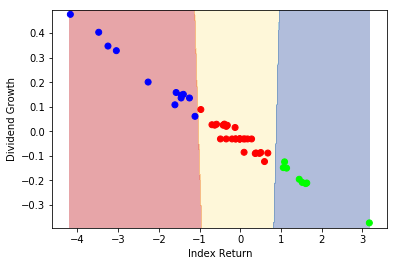

In [73]:
plot_classifier(data=x[:50,:],target=y[:50],type="SVC",svc_kernel="rbf",C=1000)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


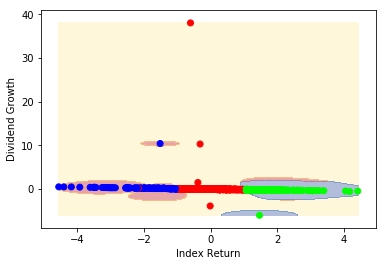

In [74]:
plot_classifier(data=x[:1500,:],target=y[:1500],type="SVC",svc_kernel="rbf",C=1000)